##### Bastien AVRILLON et Guillaume GIESSNER (Groupe n°4)

# <center>Mini-projet 4 d'Optimisation - RESTAURATION D'IMAGES</center>

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import math
from scipy.ndimage import gaussian_filter

## 1 - Étude du problème d'optimisation

#### Question 1 -

Les variables de décisions sont les $N = n \times m$ pixel de l'images qui forment donc un vecteur $z \in \mathbb{R}^{n \times m}$. Par commodité, on indice ces variables par leur position dans l'image, en voyant $z$ comme une matrice de $\mathcal{M}_{n \times m}(\mathbb{R})$.

Le problème de restauration d’image consiste à minimiser la fonction coût suivante :

$\begin{aligned}
f \colon \mathbb{R}^{n \times m} \to \mathbb{R} \\
z \mapsto f(z) & = \dfrac{1}{2} \| z - u_b \|_2^2 + \sum_{i,j} \| \nabla z(i,j) \|_2^2 \\
                &= \sum_{1 \leq i \leq n \; , \; 1 \leq j \leq m} \dfrac{1}{2} (z(i,j) - u_b(i,j))^2 \\
                &+ \sum_{1 \leq j < m} \left( z(n, j+1) - z(n, j) \right)^2 \\ 
                &+ \sum_{1 \leq i < n} \left( z(i+1, m) - z(i, m) \right)^2 \\
                &+ \sum_{\substack{1 \leq i < n \\ 1 \leq j < m}} \left( z(i+1, j) - z(i, j) \right)^2 + \left( z(i, j+1) - z(i, j) \right)^2
\end{aligned}$

On a effectivement  $\|\nabla u(i,j)\|_2^2 = \nabla_x u(i,j)^2 + \nabla_y u(i,j)^2 $, donc :

$ \begin{aligned}
\sum_{i,j} \| \nabla u(i,j) \|_2^2 &= \sum_{1 \leq i \leq n \; , \; 1 \leq j \leq m} \nabla_x u(i,j)^2 + \nabla_y u(i,j)^2 \\
&= \sum_{1 \leq j < n} \left( u(n, j+1) - u(n, j) \right)^2 + 
    \sum_{1 \leq i < n} \left( u(i+1, n) - u(i, n) \right)^2
    \sum_{1 \leq i < n \; , \; 1 \leq j < m} \left( u(i+1, j) - u(i, j) \right)^2 + \left( u(i, j+1) - u(i, j) \right)^2 \end{aligned}$

La contrainte imposée dans la minimisation est définie par :

$\begin{aligned}
c \colon \mathbb{R}^{2n \times m} &\to \mathbb{R}^{2n \times m}  \\
z &\mapsto c(z) = \begin{cases} 
-z(i,j) & \text{si } 1 \leq i \leq n, \\ 
z(i,j) - 1 & \text{si } n + 1 \leq i \leq 2n. 
\end{cases} 
\end{aligned}$


De cette manière, le problème de minimisation devient : $\min\limits_{z \in \mathbb{R}^{n \times m},\ c(z) \leq 0} f(z)$


#### Question 2 -

$ u \mapsto \frac{1}{2} \| u - u_b \|_2^2 $ est une fonction quadratique de matrice héssienne $I_{nm}$ (qui est symétrique positive) donc convexe, 

$ u \mapsto \sum_{i,j} \| \nabla u(i,j) \|_2^2 $ est également convexe, car comme détaillé par le calcul à la question précédente, elle s'écrit comme 3 sommes de termes de la forme $ u \mapsto (u(k,l) - u(p,q))^2 $, qui sont eux-même convexe par composition préservant la convexité de l'application linéaire $ u \mapsto u(k,l) - u(p,q) $ avec la fonction carré qui est convexe sur $\mathbb{R}$.

Ainsi, $f$ est convexe, comme somme de ceux fonctions convexes.

La différentiabilité de cette fonction $f$ provient du fait qu'elle est une fonction polynomiale (en les coordonnées de la base canonique de $\mathbb{R}^{n \times m}$),comme détaillé par le calcul à la question précédente.

#### Question 3 -

Montrons que le gradient de la fonction $ f $ est donné par $\nabla f(u) = u - u_b - 2 \text{div}(\nabla u) = u - u_b - 2 \Delta u$

La fonction $ f $ est définie par $f(u) = \frac{1}{2} \|u - u_b\|^2 + \sum_{(i,j)} \|\nabla u(i, j)\|^2$

On a pour le premier terme $\nabla \left( \frac{1}{2} \|u - u_b\|^2 \right) = \nabla \left( \frac{1}{2} \sum_{(i,j)} (u(i,j) - u_b(i,j))^2 \right) = u - u_b$

Pour le second, il s'agit donc de montrer que $\nabla \left( \sum_{(i,j)} \|\nabla u_{(i,j)}\|^2 \right) = -2 \, \mathrm{div}(\nabla u)$

Posons $ \beta_2(u) = \sum_{(i,j)} \|\nabla u_{(i,j)}\|^2$, et cherchons le gradient de cette fonction $\nabla \beta_2$ :

$$\begin{aligned}
\beta_2(u) &= \sum_{1 \leq j < m} \left( u(n, j+1) - u(n, j) \right)^2 \\ 
                &+ \sum_{1 \leq i < n} \left( u(i+1, m) - u(i, m) \right)^2 \\
                &+ \sum_{\substack{1 \leq i < n \\ 1 \leq j < m}} \left( u(i+1, j) - u(i, j) \right)^2 + \left( u(i, j+1) - u(i, j) \right)^2
\end{aligned}$$

Donc, en prenant le gradient :


$$\begin{aligned}
\nabla \beta_2(u) &= \sum_{1 \leq j < m} 2\left( u(n, j+1) - u(n, j) \right) \nabla \left( u(n, j+1) - u(n, j) \right) \\ 
                &+ \sum_{1 \leq i < n} 2\left( u(i+1, m) - u(i, m) \right) \nabla \left( u(i+1, m) - u(i, m) \right) \\
                &+ \sum_{\substack{1 \leq i < n \\ 1 \leq j < m}} 2\left( u(i+1, j) - u(i, j) \right) \nabla \left( u(i+1, j) - u(i, j) \right) + 2\left( u(i, j+1) - u(i, j) \right) \nabla \left( u(i, j+1) - u(i, j) \right)
\end{aligned}$$

On calcule les gradient des fonctions intervenant dans les sommes précédentes. On a noté $E_{ij}$ les matrices de la base canonique de $\mathcal{M}_{n \times m}(\mathbb{R})$ :

$$\begin{aligned}
\nabla \beta_2(u) &= \sum_{1 \leq j < m} 2\left( u(n, j+1) - u(n, j) \right) \left( E_{n, j+1} - E_{n, j} \right) \\ 
                &+ \sum_{1 \leq i < n} 2\left( u(i+1, m) - u(i, m) \right) \left( E_{i+1, m} - E_{i, m} \right) \\
                &+ \sum_{\substack{1 \leq i < n \\ 1 \leq j < m}} 2\left( u(i+1, j) - u(i, j) \right) \left( E_{i+1, j} - E_{i, j} \right) + 2\left( u(i, j+1) - u(i, j) \right) \left( E_{i, j+1} - E_{i, j} \right) \\
\end{aligned}$$

On découpe ensuite les sommes et on les ré-indexe pour une meilleure lisibilité :

$$\begin{aligned}
\nabla \beta_2(u) &= \sum_{1 \leq j < m} 2\left( u(n, j+1) - u(n, j) \right) E_{n, j+1} \\ 
                &- \sum_{1 \leq j < m} 2\left( u(n, j+1) - u(n, j) \right) E_{n, j}  \\ 
                &+ \sum_{1 \leq i < n} 2\left( u(i+1, m) - u(i, m) \right) E_{i+1, m} \\
                &- \sum_{1 \leq i < n} 2\left( u(i+1, m) - u(i, m) \right) E_{i, m} \\
                &+ \sum_{\substack{1 \leq i < n \\ 1 \leq j < m}} 2\left( u(i+1, j) - u(i, j) \right) E_{i+1, j}\\
                &- \sum_{\substack{1 \leq i < n \\ 1 \leq j < m}} 2\left( u(i+1, j) - u(i, j) \right) E_{i, j}  \\
                &+ \sum_{\substack{1 \leq i < n \\ 1 \leq j < m}} 2\left( u(i, j+1) - u(i, j) \right) E_{i, j+1} \\
                &- \sum_{\substack{1 \leq i < n \\ 1 \leq j < m}} 2\left( u(i, j+1) - u(i, j) \right) E_{i, j} \\
\nabla \beta_2(u) &= \sum_{2 \leq j \leq m} 2\left( u(n, j) - u(n, j-1) \right) E_{n, j} \\ 
                &- \sum_{1 \leq j < m} 2\left( u(n, j+1) - u(n, j) \right) E_{n, j}  \\ 
                &+ \sum_{2 \leq i \leq n} 2\left( u(i, m) - u(i-1, m) \right) E_{i, m} \\
                &- \sum_{1 \leq i < n} 2\left( u(i+1, m) - u(i, m) \right) E_{i, m} \\
                &+ \sum_{\substack{2 \leq i \leq n \\ 1 \leq j < m}} 2\left( u(i, j) - u(i-1, j) \right) E_{i, j}\\
                &- \sum_{\substack{1 \leq i < n \\ 1 \leq j < m}} 2\left( u(i+1, j) - u(i, j) \right) E_{i, j}  \\
                &+ \sum_{\substack{1 \leq i < n \\ 2 \leq j \leq m}} 2\left( u(i, j-1) - u(i, j-1) \right) E_{i, j} \\
                &- \sum_{\substack{1 \leq i < n \\ 1 \leq j < m}} 2\left( u(i, j+1) - u(i, j) \right) E_{i, j}

\end{aligned}$$

On peut alors faire apparaître le gradient discret dans l'expression précédente :

$$\begin{aligned}
\nabla \beta_2(u) &= \sum_{2 \leq j \leq m} 2\left( \nabla_y u(n,j-1) \right) E_{n, j} \\ 
                &- \sum_{1 \leq j < m} 2\left( \nabla_y u(n,j) \right) E_{n, j}  \\ 
                &+ \sum_{2 \leq i \leq n} 2\left( \nabla_x u(i-1,m) \right) E_{i, m} \\
                &- \sum_{1 \leq i < n} 2\left( \nabla_x u(i,m) \right) E_{i, m} \\
                &+ \sum_{\substack{2 \leq i \leq n \\ 1 \leq j < m}} 2\left( \nabla_x u(i-1,j) \right) E_{i, j}\\
                &- \sum_{\substack{1 \leq i < n \\ 1 \leq j < m}} 2\left( \nabla_x u(i,j) \right) E_{i, j}  \\
                &+ \sum_{\substack{1 \leq i < n \\ 2 \leq j \leq m}} 2\left( \nabla_y u(i,j-1) \right) E_{i, j} \\
                &- \sum_{\substack{1 \leq i < n \\ 1 \leq j < m}} 2\left( \nabla_y u(i,j) \right) E_{i, j} \\
\end{aligned}$$

On rentre les 4 premières sommes dans les 4 secondes :

$$\begin{aligned}
\nabla \beta_2(u) &= \sum_{\substack{2 \leq i \leq n \\ 1 \leq j \leq m}} 2\left( \nabla_x u(i-1,j) \right) E_{i, j}\\
                &- \sum_{\substack{1 \leq i \leq n \\ 1 \leq j < m}} 2\left( \nabla_x u(i,j) \right) E_{i, j}  \\
                &+ \sum_{\substack{1 \leq i \leq n \\ 2 \leq j \leq m}} 2\left( \nabla_y u(i,j-1) \right) E_{i, j} \\
                &- \sum_{\substack{1 \leq i < n \\ 1 \leq j \leq m}} 2\left( \nabla_y u(i,j) \right) E_{i, j} \\
                
                &= \sum_{\substack{1 < i < n \\ 1 \leq j \leq m}} 2\left( \nabla_x u(i-1,j) \right) E_{i, j} + \sum_{\substack{1 \leq j \leq m}} 2\left( \nabla_x u(n-1,j) \right) E_{n, j}\\
                &- \sum_{\substack{1 < i < n \\ 1 \leq j < m}} 2\left( \nabla_x u(i,j) \right) E_{i, j} - \sum_{\substack{1 \leq j < m}} 2\left( \nabla_x u(1,j) \right) E_{1, j} - [\sum_{\substack{1 \leq j < m}} 2\left( \nabla_x u(n,j) \right) E_{n, j} ]  \\
                &+ \sum_{\substack{1 \leq i \leq n \\ 1 < j < m}} 2\left( \nabla_y u(i,j-1) \right) E_{i, j} + \sum_{\substack{1 \leq i \leq n}} 2\left( \nabla_y u(i,m-1) \right) E_{i, m} \\
                &- \sum_{\substack{1 \leq i < n \\ 1 < j < m}} 2\left( \nabla_y u(i,j) \right) E_{i, j} - \sum_{\substack{1 \leq i < n}} 2\left( \nabla_y u(i,1) \right) E_{i, 1} - [\sum_{\substack{1 \leq i < n}} 2\left( \nabla_y u(i,m) \right) E_{i, m} ]\\
\end{aligned}$$

Les termes encadrés sont nuls, par définition du gradient discret. Finalement, l'expression suivante permet bien de retrouver celle de $-2 \mathrm{div}(\nabla u)$ : 

$$\begin{aligned}
\nabla \beta_2(u) &= \sum_{\substack{1 < i < n \\ 1 \leq j \leq m}} 2\left( \nabla_x u(i-1,j) \right) E_{i, j} + \sum_{\substack{1 \leq j \leq m}} 2\left( \nabla_x u(n-1,j) \right) E_{n, j}\\
                &- \sum_{\substack{1 < i < n \\ 1 \leq j < m}} 2\left( \nabla_x u(i,j) \right) E_{i, j} - \sum_{\substack{1 \leq j < m}} 2\left( \nabla_x u(1,j) \right) E_{1, j}  \\
                &+ \sum_{\substack{1 \leq i \leq n \\ 1 < j < m}} 2\left( \nabla_y u(i,j-1) \right) E_{i, j} + \sum_{\substack{1 \leq i \leq n}} 2\left( \nabla_y u(i,m-1) \right) E_{i, m} \\
                &- \sum_{\substack{1 \leq i < n \\ 1 < j < m}} 2\left( \nabla_y u(i,j) \right) E_{i, j} - \sum_{\substack{1 \leq i < n}} 2\left( \nabla_y u(i,1) \right) E_{i, 1} \\
\end{aligned}$$

D'où, pour ce second terme, $\nabla \left( \sum_{(i,j)} \|\nabla u_{(i,j)}\|^2 \right) = \nabla \beta_2(u) = -2 \, \mathrm{div}(\nabla u)$. Ce qui conclut la démonstration.

## 2 - Résolution numérique

#### Question 4 -

In [72]:
def matrice_to_image(mat):
    mat_prime = mat[:,:,np.newaxis]
    return np.stack([mat]*3, axis=-1)

In [73]:
def matrice_to_vecteur(mat):
    return np.ravel(mat)

def vecteur_to_matrice(vect):
    return(vect.reshape(n,m))

In [74]:
#L'image d'origine est en RGB, on l'importe en noir et blanc avec 1 canal :
img_noise = plt.imread('robot_noise.jpg')[...,0]          
img_no_noise = plt.imread('robot_no_noise.jpg')[...,0]

#L'importation code les pixels sur des entiers de 8bits, on veut des flotants de 32bits :
img_noise = img_noise.astype(np.float32) / 255.0
img_no_noise = img_no_noise.astype(np.float32) / 255.0

In [75]:
n,m = img_noise.shape #Dimension des images

In [76]:
def f(u):
    difference =  u -img_noise
    terme_1 = 0.5*np.linalg.norm(difference.reshape(-1),2)**2
    terme_2 = np.linalg.norm(grad_img(u).ravel(),2)**2
    res = terme_1 + terme_2
    return res

In [77]:
def grad_img(u):                                    #Gradient d'une image
    grad_x = np.zeros_like(u)
    grad_y = np.zeros_like(u)
    grad_x[:-1, :] = u[1:, :] - u[:-1, :]
    grad_y[:, :-1] = u[:, 1:] - u[:, :-1]
    grad_im = np.stack((grad_x, grad_y), axis=-1)
    return grad_im

def divergence(v):                              #Divergence d'une fonction
    div = np.zeros_like(v)[:,:,0]
    div[1:-1,:] += v[1:-1,:,0] - v[:-2, :,0]
    div[:, 1:-1] += v[:,1:-1,1] - v[:,:-2,1]
    div[0,:] += v[0,:,0]
    div[:,0] += v[:,0,1]
    div[-1,:] -= v[-2,:,0]
    div[:,-1] -= v[:,-2,1]
    return div

def laplacien(u):                               #Laplacien d'une image
    grad_im = grad_img(u)
    return divergence(grad_im)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.8431373..2.4431374].


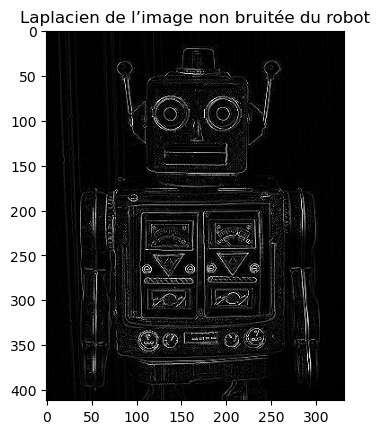

In [78]:
plt.imshow(matrice_to_image(laplacien(img_no_noise)),cmap='gray')
plt.title("Laplacien de l’image non bruitée du robot")
plt.show()

#### Question 5 -

In [79]:
def grad_f(u):
    res = u -img_noise -2*laplacien(u) 
    return res

In [80]:
#Vérification de l'implémentation du gradient de f

def approximation_grad_f(u,h,epsilon):
    return (f(u+epsilon*h)-f(u-epsilon*h))/(2*epsilon)

u1 = img_no_noise
epsilon = 0.00001
h = np.random.rand(n,m)

print(approximation_grad_f(u1,h,epsilon),np.trace(np.dot(np.transpose(grad_f(u1)),h)))

-722.1482961540459 -722.1483285381172


In [103]:
def optim_gradient_fixed_step(grad_fun, x0, l, max_iter = 10000, epsilon_grad_fun = 0.05):
    k = 0
    xk = x0
    grad_f_xk = grad_fun(xk)
    nb_iterations = 0
    while ((k<max_iter) and (np.linalg.norm(grad_f_xk.reshape(-1),1)>epsilon_grad_fun)):
        pk = -grad_f_xk
        xk = xk + l*pk
        grad_f_xk = grad_fun(xk)
        k = k + 1
        nb_iterations += 1
    return xk,nb_iterations

u_optim_fixed_step,nb_iterations = optim_gradient_fixed_step(grad_f, img_noise, 0.05)

print("Nombre d'itérations de l'algorithme : ",nb_iterations)

Nombre d'itérations de l'algorithme :  179


In [82]:
# Analyse des résultats :

norme_grad_ini = np.linalg.norm((img_noise).reshape(-1),1)
cout_ini = f(img_noise)

norme_grad_fin = np.linalg.norm(grad_f(u_optim_fixed_step).reshape(-1),1)
cout_fin = f(u_optim_fixed_step)

print("Initialement (norme du gradient,cout) : ", norme_grad_ini,cout_ini)
print("Finalement (norme du gradient,cout) : ", norme_grad_fin,cout_fin)

Initialement (norme du gradient,cout) :  55117.09 20810.400112951407
Finalement (norme du gradient,cout) :  0.049389534 2535.7833000141763


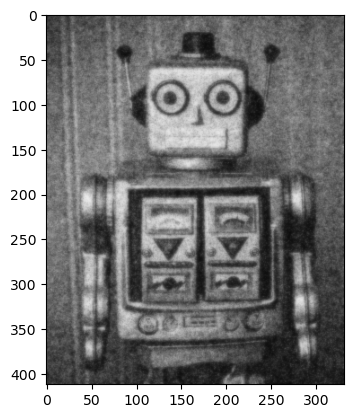

In [83]:
plt.imshow(matrice_to_image(u_optim_fixed_step), cmap='gray')

→ On obtient distinctement l'image, qui semble effectivement dé-bruitée, bien qu'elle semble peut-être légèrement plus brumeuse que l'originale. Les détails sont en effet moins dessinés. Le gradient est proche de 0,05 pour 180 itérations (exécution en un temps raisonable), mais non nul. On en conclue que cette méthode de descente du gradient pourrait être perfectionnée, notamment en choisissant un pas variable (avec une recherche linéaire par exemple).

In [ ]:
# #Méthode de descente de gradient à pas variable :

# Retirer les commentaires : Ctrl + K puis U

# # Conditions de Wolfe
# def wolfe_step(fun, grad_fun, xk, pk, c1 = 0.25, c2 = 0.75, M = 1000):
#     l_moins = 0
#     l_plus = 0
#     f_xk = fun(vecteur_to_matrice(xk))
#     grad_f_xk = matrice_to_vecteur(grad_fun(vecteur_to_matrice(xk)))
#     li = 0.05 #- 2*0.1*abs(f_x) / np.dot(grad_f_x,d)
#     i = 0
#     while(i < M):
#         if (fun(vecteur_to_matrice(xk+li*pk))>(f_xk+c1*li*np.dot(grad_f_xk,pk))):
#             l_plus = li
#             li = (l_moins+l_plus)/2.0
#         else:
#             if (np.dot(matrice_to_vecteur(grad_fun(vecteur_to_matrice(xk+li*pk))),pk) < c2*np.dot(grad_f_xk,pk)):
#                 l_moins = li
#                 if (l_plus == 0):
#                     li = 2*li
#                 else:
#                     li = (l_moins+l_plus)/2.0
#             else:
#                 #print("Nb itérations : ", i)
#                 return li
#         i = i + 1
#     #print("Trop d'itérations de Wolfe")
#     return li
    

# # Méthode de descente de gradient avec recherche linéaire suivant les conditions de Wolfe
# def optim_gradient_variable_step(fun, grad_fun, x0, max_iter = 100, epsilon_grad_fun = 10):
#     k = 0
#     xk = x0
#     grad_f_xk = grad_fun(xk)
#     nb_iterations = 0
#     while ((k<max_iter) and (np.linalg.norm(grad_f_xk.reshape(-1),1)>epsilon_grad_fun)):
#         pk = -grad_f_xk
#         lk = wolfe_step(fun, grad_fun, matrice_to_vecteur(xk), matrice_to_vecteur(pk))
#         xk = xk + lk*pk
#         grad_f_xk = grad_fun(xk)
#         k = k + 1
#         nb_iterations += 1
#     return xk,nb_iterations

# u_optim_variable_step,nb_iterations = optim_gradient_variable_step(f,grad_f, img_noise)

# # Analyse des résultats :

# norme_grad_ini = np.linalg.norm((img_noise).reshape(-1),1)
# cout_ini = f(img_noise)

# norme_grad_fin = np.linalg.norm(grad_f(u_optim_variable_step).reshape(-1),1)
# cout_fin = f(u_optim_variable_step)

# print("Nombre d'itérations de l'algorithme : ",nb_iterations)
# print("Initialement (norme du gradient,cout) : ", norme_grad_ini,cout_ini)
# print("Finalement (norme du gradient,cout) : ", norme_grad_fin,cout_fin)

# plt.imshow(matrice_to_image(u_optim_fixed_step), cmap='gray')

KeyboardInterrupt: 

#### Question 6 -

In [84]:
def RMSE(u):
    difference =  img_no_noise - u 
    numerateur = np.linalg.norm(difference.reshape(-1),2)**2
    denominateur = math.prod(u.shape)
    res = (numerateur/denominateur)**0.5
    return res

print(f"RMSE finale pour l’image trouvée par la minimisation via une méthode de descente de gradient à pas fixe : {RMSE(u_optim_fixed_step)}")
print(f"RMSE pour l'image bruitée d'origine : {RMSE(img_noise)}")
print(f"Taux de variation RMSE : {(RMSE(u_optim_fixed_step)-RMSE(img_noise))/RMSE(img_noise)}")

RMSE finale pour l’image trouvée par la minimisation via une méthode de descente de gradient à pas fixe : 0.09647666663823135
RMSE pour l'image bruitée d'origine : 0.1852844596946583
Taux de variation RMSE : -0.47930513548075643


→ Le RMSE de l'image débruitée via la méthode de descente du gradient est plus faible que l'image bruitée d'origine (diminution de près de 50%). L'image débruitée sera donc plus proche de l'orginale. 
La diminution toutefois modérée de la valeur de cet indicateur RMSE peut laisser penser qu'il ne s'agit peut-être pas du meilleur à choisir pour évaluer les performances d'une méthode de reconstruction d'une image par rapport à une image d'origine (parmi les alternatives : rapport signal).

#### Question 7 -

In [85]:
u0 = matrice_to_vecteur(img_noise)

def f_scipy(u):
    return f(vecteur_to_matrice(u))

def grad_f_scipy(u):
    return matrice_to_vecteur(grad_f(vecteur_to_matrice(u)))

In [86]:
#Méthode L-BFGS-B (Quasi-Newton avec une projection permettant de rester dans les bornes fixées):

resultat = optimize.minimize(f_scipy,u0,method='L-BFGS-B',jac=grad_f_scipy)
u_vect_minimisation_scipy = resultat.x
u_minimisation_scipy_BFGS = vecteur_to_matrice(u_vect_minimisation_scipy)
print(resultat)

norme_grad_fin_BFGS = np.linalg.norm(grad_f(u_minimisation_scipy_BFGS).reshape(-1),1)
cout_fin_BFGS = f(u_minimisation_scipy_BFGS)
print("Finalement avec L-BFGS-B (grad,cout) : ", norme_grad_fin_BFGS,cout_fin_BFGS)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 2535.7833600787962
        x: [ 2.590e-01  2.474e-01 ...  9.020e-02  1.039e-01]
      nit: 20
      jac: [ 7.769e-05  3.353e-06 ... -2.125e-05  1.605e-05]
     nfev: 33
     njev: 33
 hess_inv: <136784x136784 LbfgsInvHessProduct with dtype=float64>
Finalement avec L-BFGS-B (grad,cout) :  4.199647070537078 2535.7833980777255


In [87]:
#Méthode CG (Gradient conjugué : sans hésienne et sans contraintes)

resultat = optimize.minimize(f_scipy,u0,method='CG',jac=grad_f_scipy)
u_vect_minimisation_scipy_CG = resultat.x
u_minimisation_scipy_CG = vecteur_to_matrice(u_vect_minimisation_scipy_CG)
print(resultat)

norme_grad_fin_CG = np.linalg.norm(grad_f(u_minimisation_scipy_CG).reshape(-1),1)
cout_fin_CG = f(u_minimisation_scipy_CG)
print("Finalement avec CG (grad,cout) : ", norme_grad_fin_CG,cout_fin_CG)

 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 2535.7833873737945
       x: [ 2.590e-01  2.474e-01 ...  9.021e-02  1.039e-01]
     nit: 16
     jac: [ 1.241e-04 -6.126e-05 ...  2.577e-05  2.388e-05]
    nfev: 56
    njev: 44
Finalement avec CG (grad,cout) :  10.311832 2535.7833873737945


In [88]:
print(f"RMSE finale pour l’image trouvée par la minimisation via une méthode de descente de gradient à pas fixe : {RMSE(u_optim_fixed_step)}")
print(f"RMSE finale pour l’image trouvée par la minimisation via scipy L-BFGS-B : {RMSE(u_minimisation_scipy_BFGS)}")
print(f"RMSE finale pour l’image trouvée par la minimisation via scipy CG : {RMSE(u_minimisation_scipy_CG)}")
print(f"RMSE pour l'image bruitée d'origine : {RMSE(img_noise)}")

RMSE finale pour l’image trouvée par la minimisation via une méthode de descente de gradient à pas fixe : 0.09647666663823135
RMSE finale pour l’image trouvée par la minimisation via scipy L-BFGS-B : 0.09647491124315541
RMSE finale pour l’image trouvée par la minimisation via scipy CG : 0.09647389207447934
RMSE pour l'image bruitée d'origine : 0.1852844596946583


→ On constate que les valeurs de RMSE  images obtenues so quasi-ment identiques, ce qui témoignerait d'une qualité de débruitage équivalente des 3 algorithmes. De même la valeur du coût en fin d'itération est identique. Néanmoins, les 3 méthodes diffèrent par la valeur de la norme du gradient en fin d'itération. Le code manuel la décroit bien plus fortement (norme du gradient 100 fois moindre), mais au prix d'un plus grand nombre d'itérations (près de 10 fois suppérieur).

#### Question 8 -

In [89]:
def TV_L2(u):
    difference =  u -img_noise
    terme_1 = 0.5*np.linalg.norm(difference.reshape(-1),2)**2
    terme_2 = np.linalg.norm(grad_img(u).ravel(),1)
    res = terme_1 + terme_2
    return res

→ Montrons que $\text{TV-L2}$ est une fonction convexe.

Définissons les fonction :
$$\begin{aligned}
\alpha \colon \mathbb{R}^{n \times m} \to \mathbb{R} \\
u \mapsto \alpha(u) & = \dfrac{1}{2} \| u - u_b \|_2^2 \\
\end{aligned}$$
$$\begin{aligned}
\gamma \colon \mathbb{R}^{n \times m} \to \mathbb{R} \\
u \mapsto \gamma(u) & = \sum_{i,j} \| \nabla u(i,j) \|_1 \\
\end{aligned}$$

Telles que $(\text{TV-L2}) = \alpha + \gamma$. 
On a déjà montré dans à la question 2 que la fonction $\alpha$ est convexe. Reste à montrer la convexité de $\gamma$. Explicitons cette fonction :

$\begin{aligned}
\gamma(u) & = \sum_{i,j} \| \nabla u(i,j) \|_1 \\
                &= \sum_{1 \leq j < m} \left| u(n, j+1) - u(n, j) \right| \\ 
                &+ \sum_{1 \leq i < n} \left| u(i+1, m) - u(i, m) \right| \\
                &+ \sum_{\substack{1 \leq i < n \\ 1 \leq j < m}} \left| u(i+1, j) - u(i, j) \right| + \left| u(i, j+1) - u(i, j) \right|
\end{aligned}$

On constate donc que $\gamma$ est une somme de fonctions, chacune d'entre elles étant convexe comme composée d'une fonction linéaire de $\mathbb{R}^{n \times m}$  dans $\mathbb{R}$ par la fonction valeur absolue (qui est convexe) sur $\mathbb{R}^{n \times m}$. On en déduit la convexité de $\gamma$.

**Bilan :** Le problème, défini sur l'ensemble convexe $\mathbb{R}^{n \times m}$ est convexe.


→ Montrons que $\text{TV-L2}$ n'est pas différentiable, en raisonnant par l'absurde. 
On suppose donc que cette application $\text{TV-L2}$ est différentiable. On reprend les notations précedemment introduites.

On a déjà montré dans à la question 2 que la fonction $\beta$ est différentiable.
Par différence de fonctions différentiable, l'application $\gamma = (TV-L2) - \beta$ est elle aussi différentiable sur $\mathbb{R}^{n \times m}$.

De plus, pout tout $t \in \mathbb{R}$, définissons $u_t = tE_{11}$ la matrice (ou vecteur) dont tous les coefficients sont nuls à l'exception du premier égal à $t$.
On obtient par le calcul : $$ \forall (i,j) \in [\![1, n]\!] \times [\![1, m]\!], \nabla u(i,j) =  \left(-\boldsymbol{\delta}_{1i} \boldsymbol{\delta}_{1j} t,-\boldsymbol{\delta}_{1i} \boldsymbol{\delta}_{1j} t \right)$$

L'application suivante est bien définie et de classe $C^1$ sur $\mathbb{R}$, car chacune de ses fonctions composantes l'est :
$$\begin{aligned}
\psi \colon \mathbb{R} \to \mathbb{R}^{n \times m} \\
t \mapsto \psi(t) &= u_t
\end{aligned}$$

Par composition d'une fonction de $C^1(\mathbb{R},\mathbb{R}^{n \times m})$ et d'une fonction différentiable sur $\mathbb{R}^{n \times m}$, on en déduit que la fonction $h = \gamma \circ \psi$ est définie et dérivable sur $\mathbb{R}$. 

Or $t \in \mathbb{R}, h(t) = \gamma (u_t) = \sum_{i,j} \| \nabla u(i,j) \|_1^2 = \| \nabla u(1,1) \|_1^2 = 2 |t|$, et sachant que la fonction valeur absolue n'est pas dérivable en 0, on en déduit que $h$ ne l'est pas non plus. Ceci est absurde et clôt notre raisonnement, car on a justement démontré la dérivabilité de $h$ sur $\mathbb{R}$.

**Bilan :** $\text{TV-L2}$ n'est pas différentiable, donc le problème n'est pas différentiable.


#### Question 9 -

Montrons qu'un sous-gradient de la fonction $ \text{TV-L2} $ est donné par $ g(u) = u - u_b - \text{div}(\text{sign}(\nabla u)) $

La fonction $ \text{TV-L2} $ est définie par $ \text{TV-L2}(u) = \frac{1}{2} \|u - u_b\|^2 + \sum_{(i,j)} \|\nabla u(i, j)\|_1 $ où $\|\nabla u(i, j)\|_1 = |\nabla_x u(i, j)| + |\nabla_y u(i, j)|$.

On a pour le premier terme, qui est différentiable en tout point, on a $\nabla \left( \frac{1}{2} \|u - u_b\|^2 \right) = \nabla \left( \frac{1}{2} \sum_{(i,j)} (u(i,j) - u_b(i,j))^2 \right) = u - u_b $

Le second terme, appelé $\gamma$ comme précédemment, est différentiable en tout point où le gradient discret de u ne possède aucune composante nulle. Montrons que son gradient sur cet ensemble est $ - \text{div}(\text{sign}(\nabla u)) $.

$\begin{aligned}
\gamma(u) & = \sum_{i,j} \| \nabla u(i,j) \|_1 \\
                &= \sum_{1 \leq j < m} \left| u(n, j+1) - u(n, j) \right| \\ 
                &+ \sum_{1 \leq i < n} \left| u(i+1, m) - u(i, m) \right| \\
                &+ \sum_{\substack{1 \leq i < n \\ 1 \leq j < m}} \left| u(i+1, j) - u(i, j) \right| + \left| u(i, j+1) - u(i, j) \right|
\end{aligned}$

Prenons le gradient dans l'expression de $\gamma$ :

$\begin{aligned}
\nabla \gamma(u) &= \sum_{1 \leq j < m} \nabla \left| u(n, j+1) - u(n, j) \right| \\ 
                &+ \sum_{1 \leq i < n} \nabla \left| u(i+1, m) - u(i, m) \right| \\
                &+ \sum_{\substack{1 \leq i < n \\ 1 \leq j < m}} \nabla \left| u(i+1, j) - u(i, j) \right| + \nabla \left| u(i, j+1) - u(i, j) \right| \\
\nabla \gamma(u) &= \sum_{1 \leq j < m} \text{sign}(u(n, j+1) - u(n, j)) \nabla \left( u(n, j+1) - u(n, j) \right) \\ 
                &+ \sum_{1 \leq i < n} \text{sign}(u(i+1, m) - u(i, m)) \nabla \left( u(i+1, m) - u(i, m) \right) \\
                &+ \sum_{\substack{1 \leq i < n \\ 1 \leq j < m}} \text{sign}(u(i+1, j) - u(i, j)) \nabla \left( u(i+1, j) - u(i, j) \right) + \text{sign}(u(i, j+1) - u(i, j)) \nabla \left( u(i, j+1) - u(i, j) \right)
\end{aligned}$

On calcule les gradient des fonctions intervenant dans les sommes précédentes. On a noté $E_{ij}$ les matrices de la base canonique de $\mathcal{M}_{n \times m}(\mathbb{R})$ :

$$\begin{aligned}
\nabla \gamma(u) &= \sum_{1 \leq j < m} \text{sign}(u(n, j+1) - u(n, j)) \left( E_{n, j+1} - E_{n, j} \right) \\ 
                &+ \sum_{1 \leq i < n} \text{sign}(u(i+1, m) - u(i, m)) \left( E_{i+1, m} - E_{i, m} \right) \\
                &+ \sum_{\substack{1 \leq i < n \\ 1 \leq j < m}} \text{sign}(u(i+1, j) - u(i, j)) \left( E_{i+1, j} - E_{i, j} \right) + \text{sign}(u(i, j+1) - u(i, j)) \left( E_{i, j+1} - E_{i, j} \right)
\end{aligned}$$

On découpe ensuite les sommes et on les ré-indexe pour une meilleure lisibilité :

$$\begin{aligned}
\nabla \gamma(u) &= \sum_{1 \leq j < m} \text{sign}\left( u(n, j+1) - u(n, j) \right) E_{n, j+1} \\ 
                &- \sum_{1 \leq j < m} \text{sign}\left( u(n, j+1) - u(n, j) \right) E_{n, j}  \\ 
                &+ \sum_{1 \leq i < n} \text{sign}\left( u(i+1, m) - u(i, m) \right) E_{i+1, m} \\
                &- \sum_{1 \leq i < n} \text{sign}\left( u(i+1, m) - u(i, m) \right) E_{i, m} \\
                &+ \sum_{\substack{1 \leq i < n \\ 1 \leq j < m}} \text{sign}\left( u(i+1, j) - u(i, j) \right) E_{i+1, j}\\
                &- \sum_{\substack{1 \leq i < n \\ 1 \leq j < m}} \text{sign}\left( u(i+1, j) - u(i, j) \right) E_{i, j}  \\
                &+ \sum_{\substack{1 \leq i < n \\ 1 \leq j < m}} \text{sign}\left( u(i, j+1) - u(i, j) \right) E_{i, j+1} \\
                &- \sum_{\substack{1 \leq i < n \\ 1 \leq j < m}} \text{sign}\left( u(i, j+1) - u(i, j) \right) E_{i, j} \\
\nabla \gamma(u) &= \sum_{2 \leq j \leq m} \text{sign}\left( u(n, j) - u(n, j-1) \right) E_{n, j} \\ 
                &- \sum_{1 \leq j < m} \text{sign}\left( u(n, j+1) - u(n, j) \right) E_{n, j}  \\ 
                &+ \sum_{2 \leq i \leq n} \text{sign}\left( u(i, m) - u(i-1, m) \right) E_{i, m} \\
                &- \sum_{1 \leq i < n} \text{sign}\left( u(i+1, m) - u(i, m) \right) E_{i, m} \\
                &+ \sum_{\substack{2 \leq i \leq n \\ 1 \leq j < m}} \text{sign}\left( u(i, j) - u(i-1, j) \right) E_{i, j}\\
                &- \sum_{\substack{1 \leq i < n \\ 1 \leq j < m}} \text{sign}\left( u(i+1, j) - u(i, j) \right) E_{i, j}  \\
                &+ \sum_{\substack{1 \leq i < n \\ 2 \leq j \leq m}} \text{sign}\left( u(i, j-1) - u(i, j-1) \right) E_{i, j} \\
                &- \sum_{\substack{1 \leq i < n \\ 1 \leq j < m}} \text{sign}\left( u(i, j+1) - u(i, j) \right) E_{i, j}

\end{aligned}$$

On peut alors faire apparaître le gradient discret dans l'expression précédente :

$$\begin{aligned}
\nabla \gamma(u) &= \sum_{2 \leq j \leq m} \text{sign}\left( \nabla_y u(n,j-1) \right) E_{n, j} \\ 
                &- \sum_{1 \leq j < m} \text{sign}\left( \nabla_y u(n,j) \right) E_{n, j}  \\ 
                &+ \sum_{2 \leq i \leq n} \text{sign}\left( \nabla_x u(i-1,m) \right) E_{i, m} \\
                &- \sum_{1 \leq i < n} \text{sign}\left( \nabla_x u(i,m) \right) E_{i, m} \\
                &+ \sum_{\substack{2 \leq i \leq n \\ 1 \leq j < m}} \text{sign}\left( \nabla_x u(i-1,j) \right) E_{i, j}\\
                &- \sum_{\substack{1 \leq i < n \\ 1 \leq j < m}} \text{sign}\left( \nabla_x u(i,j) \right) E_{i, j}  \\
                &+ \sum_{\substack{1 \leq i < n \\ 2 \leq j \leq m}} \text{sign}\left( \nabla_y u(i,j-1) \right) E_{i, j} \\
                &- \sum_{\substack{1 \leq i < n \\ 1 \leq j < m}} \text{sign}\left( \nabla_y u(i,j) \right) E_{i, j} \\
\end{aligned}$$

On rentre les 4 premières sommes dans les 4 secondes :

$$\begin{aligned}
\nabla \gamma(u) &= \sum_{\substack{2 \leq i \leq n \\ 1 \leq j \leq m}} \text{sign}\left( \nabla_x u(i-1,j) \right) E_{i, j}\\
                &- \sum_{\substack{1 \leq i \leq n \\ 1 \leq j < m}} \text{sign}\left( \nabla_x u(i,j) \right) E_{i, j}  \\
                &+ \sum_{\substack{1 \leq i \leq n \\ 2 \leq j \leq m}} \text{sign}\left( \nabla_y u(i,j-1) \right) E_{i, j} \\
                &- \sum_{\substack{1 \leq i < n \\ 1 \leq j \leq m}} \text{sign}\left( \nabla_y u(i,j) \right) E_{i, j} \\
                
                &= \sum_{\substack{1 < i < n \\ 1 \leq j \leq m}} \text{sign}\left( \nabla_x u(i-1,j) \right) E_{i, j} + \sum_{\substack{1 \leq j \leq m}} \text{sign}\left( \nabla_x u(n-1,j) \right) E_{n, j}\\
                &- \sum_{\substack{1 < i < n \\ 1 \leq j < m}} \text{sign}\left( \nabla_x u(i,j) \right) E_{i, j} - \sum_{\substack{1 \leq j < m}} \text{sign}\left( \nabla_x u(1,j) \right) E_{1, j} - [\sum_{\substack{1 \leq j < m}} \text{sign}\left( \nabla_x u(n,j) \right) E_{n, j} ]  \\
                &+ \sum_{\substack{1 \leq i \leq n \\ 1 < j < m}} \text{sign}\left( \nabla_y u(i,j-1) \right) E_{i, j} + \sum_{\substack{1 \leq i \leq n}} \text{sign}\left( \nabla_y u(i,m-1) \right) E_{i, m} \\
                &- \sum_{\substack{1 \leq i < n \\ 1 < j < m}} \text{sign}\left( \nabla_y u(i,j) \right) E_{i, j} - \sum_{\substack{1 \leq i < n}} \text{sign}\left( \nabla_y u(i,1) \right) E_{i, 1} - [\sum_{\substack{1 \leq i < n}} \text{sign}\left( \nabla_y u(i,m) \right) E_{i, m} ]\\
\end{aligned}$$

Les termes encadrés sont nuls, par définition du gradient discret. Finalement, l'expression suivante permet bien de retrouver celle de $- \text{div}(\text{sign}(\nabla u)) $ : 

$$\begin{aligned}
\nabla \gamma(u) &= \sum_{\substack{1 < i < n \\ 1 \leq j \leq m}} \text{sign}\left( \nabla_x u(i-1,j) \right) E_{i, j} + \sum_{\substack{1 \leq j \leq m}} \text{sign}\left( \nabla_x u(n-1,j) \right) E_{n, j}\\
                &- \sum_{\substack{1 < i < n \\ 1 \leq j < m}} \text{sign}\left( \nabla_x u(i,j) \right) E_{i, j} - \sum_{\substack{1 \leq j < m}} \text{sign}\left( \nabla_x u(1,j) \right) E_{1, j}  \\
                &+ \sum_{\substack{1 \leq i \leq n \\ 1 < j < m}} \text{sign}\left( \nabla_y u(i,j-1) \right) E_{i, j} + \sum_{\substack{1 \leq i \leq n}} \text{sign}\left( \nabla_y u(i,m-1) \right) E_{i, m} \\
                &- \sum_{\substack{1 \leq i < n \\ 1 < j < m}} \text{sign}\left( \nabla_y u(i,j) \right) E_{i, j} - \sum_{\substack{1 \leq i < n}} \text{sign}\left( \nabla_y u(i,1) \right) E_{i, 1} \\
\end{aligned}$$

D'où, pour ce second terme, $\nabla \left( \sum_{(i,j)} |\nabla u_{(i,j)}| \right) = \nabla \gamma(u) = - \text{div}(\text{sign}(\nabla u)) $. Ce qui conclut la démonstration de l'expression du gradient en tout point u où le gradient discret de u ne possède aucune composante nulle.



Pour déterminer le sous-différentiel de $\gamma$ en un point $v$ où $\nabla v$ possède au moins une composante nulle, on utilise les 2 perturbations introduites dans $v^{+}_{\frac{1}{k}}$ et $v^{-}_{\frac{1}{k}}$ ci-dessous :

On pose 
$
\alpha = \frac{1}{n \times m} \times \min \left(
\min_{\substack{(i,j) \\ \nabla v(i,j) \ne 0}} |\nabla_x v(i,j)| \quad , \quad
\min_{\substack{(i,j) \\ \nabla v(i,j) \ne 0}} |\nabla_y v(i,j)|
\right) > 0
$

puis $\varepsilon \in ]0, \alpha[$,

$
v^{+}_{\varepsilon} = v +
\begin{pmatrix}
\varepsilon & 2\varepsilon & 3\varepsilon & \cdots & j\varepsilon & \cdots & 3m\varepsilon \\
2\varepsilon & 2\cdot2\varepsilon & 3\cdot2\varepsilon & & & & \\
3\varepsilon & 2\cdot3\varepsilon & 3\cdot3\varepsilon & & & & \\
\vdots & & & \ddots & & & \\
i\varepsilon & & & & & & \\
\vdots & & & & & & nm\varepsilon \\
\end{pmatrix}
$

$
v^{-}_{\varepsilon} = v -
\begin{pmatrix}
\varepsilon & 2\varepsilon & 3\varepsilon & \cdots & j\varepsilon & \cdots & 3m\varepsilon \\
2\varepsilon & 2\cdot2\varepsilon & 3\cdot2\varepsilon & & & & \\
3\varepsilon & 2\cdot3\varepsilon & 3\cdot3\varepsilon & & & & \\
\vdots & & & \ddots & & & \\
i\varepsilon & & & & & & \\
\vdots & & & & & & nm\varepsilon \\
\end{pmatrix}
$

où les matrices introduites (avec les pointillés) sont $(i \times j \times \varepsilon)_{(i,j) \in \llbracket 1,n \rrbracket \times \llbracket 1,m \rrbracket}$. Par construction, on aussure que $v^{+}_{\varepsilon}$ et $v^{-}_{\varepsilon}$ sont telles que $\nabla v^{+}_{\varepsilon}$ et $\nabla v^{-}_{\varepsilon}$ ne possèdent aucune composante nulle.

On utilise alors $ \varepsilon = \frac{1}{k}$, sachant qu'à partir d'un certain rang, $\frac{1}{k} \in ]0, \alpha[$. On obtient alors : $\lim_{k \to +\infty} v^{+}_{\frac{1}{k}} = \lim_{k \to +\infty} v^{-}_{\frac{1}{k}} = v $

Et en une composante (i,j) de $v$ où $\nabla v$ est nulle, on a
$\lim_{k \to \infty} \nabla (v^{+}_{\frac{1}{k}})_{i,j} = +1$ et $\lim_{k \to \infty} \nabla (v^{-}_{\frac{1}{k}})_{i,j} = -1$.
En un tel point, on peut prendre pour la composante (i,j) d'un sous-gradient de $\gamma$ en $v$ n'importe quel point de l'enveloppe convexe de {-1,1}, ie de [-1,1]. On retient ici 0.

Ceci permet de conclure que $g$ est bien un sous-gradient de $ \text{TV-L2} $.

#### Question 10 -

In [90]:
def g(u):
    res = u -img_noise -divergence(np.sign(grad_img(u)))
    return res

In [91]:
def optim_sous_gradient(sous_grad_fun, x0, max_iter = 10000, epsilon_variations = 1e-2):
    k = 0
    xk = x0
    lk = 0.05
    sous_grad_f_xk = sous_grad_fun(xk)
    nb_iterations = 0
    for k in range(max_iter): 
        pk = -sous_grad_f_xk
        xk = xk + lk*pk
        sous_grad_f_xk = sous_grad_fun(xk)
        nb_iterations += 1
        taux_variation = np.linalg.norm((lk*pk).reshape(-1),1) / np.linalg.norm((xk -lk*pk).reshape(-1),1) 
        if (taux_variation < epsilon_variations) :  # Condition de sortie
            break
        lk = (nb_iterations)**(-1)
    return xk,nb_iterations,taux_variation

u_optim_sous_grad,nb_iterations,taux_variation = optim_sous_gradient(g, img_noise)

print("Nombre d'itérations de l'algorithme de sous-gradient : ",nb_iterations)
print("Taux de variation final de l'algorithme de sous-gradient : ",taux_variation)

Nombre d'itérations de l'algorithme de sous-gradient :  655
Taux de variation final de l'algorithme de sous-gradient :  0.009980964


In [92]:
print(f"RMSE pour l'image bruitée d'origine : {RMSE(img_noise)}")
print(f"RMSE pour l'image obtenue par minimisation via une méthode de sous-gradient : {RMSE(u_optim_sous_grad)}")
print(f"Taux de variation RMSE : {(RMSE(u_optim_sous_grad)-RMSE(img_noise))/RMSE(img_noise)}")

RMSE pour l'image bruitée d'origine : 0.1852844596946583
RMSE pour l'image obtenue par minimisation via une méthode de sous-gradient : 0.15776292234802872
Taux de variation RMSE : -0.14853667378248567


In [93]:
cout_fin_sous_grad = TV_L2(u_optim_sous_grad)
cout_ini_bis = TV_L2(img_noise)

print("Initialement, cout = ",cout_ini_bis)
print("Finalement, cout = ", cout_fin_sous_grad)

Initialement, cout =  58892.30859375
Finalement, cout =  5219.561641582317


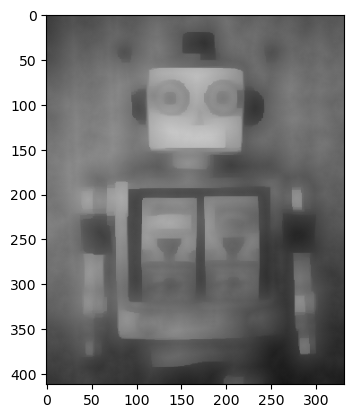

In [94]:
plt.imshow(matrice_to_image(u_optim_sous_grad), cmap='gray')

→ Le coût a été divisé par près de 11. On constate que le RMSE de l'image débruitée est plus faible que celui de l'image d'origine, mais seulement de 15%. Une partie du bruit a donc été éliminé par cette méthode (renforcement des traits principaux, suppression des détails et nuances de couleurs), mais bien moins efficacement que les méthodes précédentes utilisant la différenciabilité.  

#### Question 11 -

In [95]:
def optim_sous_gradient_momentum(sous_grad_fun, x0, beta = 0.9,max_iter = 10000, epsilon_variations = 1e-2):
    k = 0
    xk = x0
    lk = 0.05
    sous_grad_f_xk = sous_grad_fun(xk)
    pk = -sous_grad_f_xk
    nb_iterations = 0
    for k in range(max_iter): 
        xk = xk + lk*pk
        nb_iterations += 1
        taux_variation = np.linalg.norm((lk*pk).reshape(-1),1) / np.linalg.norm((xk -lk*pk).reshape(-1),1) 
        if (taux_variation < epsilon_variations) :  # Condition de sortie
            break
        lk = (nb_iterations)**(-1)
        sous_grad_f_xk = sous_grad_fun(xk)
        pk = beta*pk + (1-beta)*(-sous_grad_f_xk)
    return xk,nb_iterations,taux_variation

u_optim_sous_grad_momentum,nb_iterations,taux_variation = optim_sous_gradient_momentum(g, img_noise)

print("Nombre d'itérations de l'algorithme de sous-gradient avec momentum : ",nb_iterations)
print("Taux de variation final de l'algorithme de sous-gradient avec momentum : ",taux_variation)

Nombre d'itérations de l'algorithme de sous-gradient avec momentum :  83
Taux de variation final de l'algorithme de sous-gradient avec momentum :  0.009907286


In [96]:
cout_fin_sous_grad_momentum = TV_L2(u_optim_sous_grad_momentum)

print("Initialement, cout = ",cout_ini_bis)
print("Finalement sous-gradient, cout = ", cout_fin_sous_grad)
print("Finalement sous-gradient momentum, cout = ", cout_fin_sous_grad_momentum)

Initialement, cout =  58892.30859375
Finalement sous-gradient, cout =  5219.561641582317
Finalement sous-gradient momentum, cout =  7059.273641777341


In [97]:
print(f"RMSE pour l'image bruitée d'origine : {RMSE(img_noise)}")
print(f"RMSE pour l'image obtenue par minimisation via une méthode de sous-gradient : {RMSE(u_optim_sous_grad)}")
print(f"RMSE pour l'image obtenue par minimisation via une méthode de sous-gradient avec momentum : {RMSE(u_optim_sous_grad_momentum)}")

RMSE pour l'image bruitée d'origine : 0.1852844596946583
RMSE pour l'image obtenue par minimisation via une méthode de sous-gradient : 0.15776292234802872
RMSE pour l'image obtenue par minimisation via une méthode de sous-gradient avec momentum : 0.12520202427923757


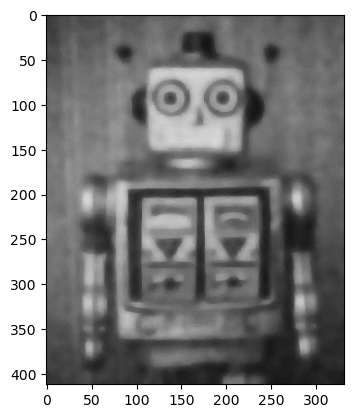

In [98]:
plt.imshow(matrice_to_image(u_optim_sous_grad_momentum), cmap='gray')

→ Le RMSE a été un peu améliorée par rapport à la méthode de sous-gradient sans momentum (amélioratio de 21% du RMSE par rapport à l'image d'origine). Le nombre d'itération a été conséquement réduit, divisé par plus de 8. Néanmoins, le coût en fin d'itération a néamoins un peu moins diminué (divisé par 8 et plus 11 par rapport à l'image d'origine). On en déduit que cette méthode de sous gradient avec momentum est plus efficace pour résoudre le problème de minimisation, ie plus rapide, sans pour autant améliorer la valeur du minimum, mais en se rapprochant néanmoins de l'image débruitée (ce que mesure le RMSE et qui est confirmé visuellement, avec une image nettement moins brumeuse), d'où une réelle pluvalue pour le procédé de débruitage.

#### Question 12 -

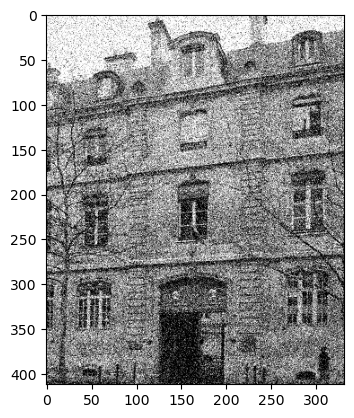

In [99]:
# L'image d'origine est en RGB, on l'importe en noir et blanc avec 1 canal :
img_bis_no_noise = plt.imread('mines_no_noise.jpg')

# L'importation code les pixels sur des entiers de 8bits, on veut des flotants de 32bits :
img_bis_no_noise = img_bis_no_noise.astype(np.float32) / 255.0

# Fabrication de l'image bruitée :
sigma = 0.2             # Ecart-type du bruit gaussien
bruit = np.random.normal(0, sigma, img_bis_no_noise.shape)
img_bis_noise = img_bis_no_noise + bruit
img_bis_noise = np.clip(img_bis_noise, 0, 1)     # On assure des pixel entre 0 et 1

plt.imshow(matrice_to_image(img_bis_noise), cmap='gray')

In [100]:
def g_2(u):
    res = u -img_bis_noise -divergence(np.sign(grad_img(u)))
    return res

def TV_L2_2(u):
    difference =  u -img_bis_noise
    terme_1 = 0.5*np.linalg.norm(difference.reshape(-1),2)**2
    terme_2 = np.linalg.norm(grad_img(u).ravel(),1)
    res = terme_1 + terme_2
    return res

Commenter les méthodes....

Nombre d'itérations de l'algorithme de sous-gradient :  521
Taux de variation final de l'algorithme de sous-gradient :  0.009989788871345036
RMSE pour l'image bruitée d'origine : 0.36137046356670216
RMSE pour l'image obtenue par minimisation via une méthode de sous-gradient : 0.28280844189874743
Initialement, cout =  58668.71359157772
Finalement, cout =  4978.319752927664


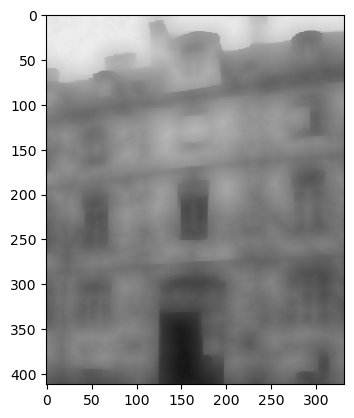

In [101]:
u_optim_sous_grad_2,nb_iterations_2,taux_variation_2 = optim_sous_gradient(g_2, img_bis_noise)

print("Nombre d'itérations de l'algorithme de sous-gradient : ",nb_iterations_2)
print("Taux de variation final de l'algorithme de sous-gradient : ",taux_variation_2)

print(f"RMSE pour l'image bruitée d'origine : {RMSE(img_bis_noise)}")
print(f"RMSE pour l'image obtenue par minimisation via une méthode de sous-gradient : {RMSE(u_optim_sous_grad_2)}")

cout_fin_sous_grad_2 = TV_L2_2(u_optim_sous_grad_2)
cout_ini_ter = TV_L2_2(img_bis_noise)

print("Initialement, cout = ",cout_ini_ter)
print("Finalement, cout = ", cout_fin_sous_grad_2)

plt.imshow(matrice_to_image(u_optim_sous_grad_2), cmap='gray')


Nombre d'itérations de l'algorithme de sous-gradient momentum :  77
Taux de variation final de l'algorithme de sous-gradient momentum :  0.009887454863358416
RMSE pour l'image bruitée d'origine : 0.36137046356670216
RMSE pour l'image obtenue par minimisation via une méthode de sous-gradient momentum : 0.28280844189874743
Initialement, cout =  58668.71359157772
Finalement, cout =  7591.480117802624


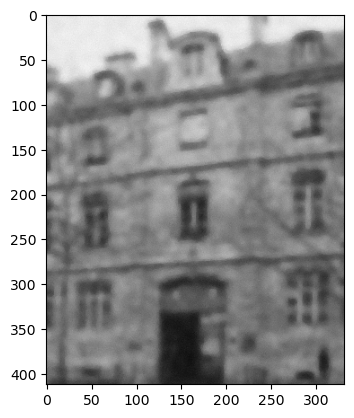

In [102]:
u_optim_sous_grad_momentum_2,nb_iterations_2,taux_variation_2 = optim_sous_gradient_momentum(g_2, img_bis_noise)

print("Nombre d'itérations de l'algorithme de sous-gradient momentum : ",nb_iterations_2)
print("Taux de variation final de l'algorithme de sous-gradient momentum : ",taux_variation_2)

print(f"RMSE pour l'image bruitée d'origine : {RMSE(img_bis_noise)}")
print(f"RMSE pour l'image obtenue par minimisation via une méthode de sous-gradient momentum : {RMSE(u_optim_sous_grad_2)}")

cout_fin_sous_grad_momentum_2 = TV_L2_2(u_optim_sous_grad_momentum_2)
cout_ini_ter = TV_L2_2(img_bis_noise)

print("Initialement, cout = ",cout_ini_ter)
print("Finalement, cout = ", cout_fin_sous_grad_momentum_2)

plt.imshow(matrice_to_image(u_optim_sous_grad_momentum_2), cmap='gray')

→ On constate que les deux méthodes disposent d'un RSME à peu près similaires. Pourtant la 2e semble dans les fait plus proche de l'image d'orgine que la 1e, ce qui traduit les limite de la caractérisation via le RMSE du débruitage.

De nouveau, le nombre d'itération a été conséquement réduit, divisé par plus de 7. Néanmoins, le coût en fin d'itération a néamoins un peu moins diminué (divisé par 8 et plus 12 par rapport à l'image d'origine). On en déduit que cette méthode de sous gradient avec momentum est toujours plus rapide, sans pour autant améliorer la valeur du minimum, mais en se rapprochant néanmoins de l'image débruitée (visuellement, avec une image nettement moins brumeuse).

Visuellement, le débruitage semble mois effectif que sur le précédent exemple du robot, peut-être à cause de contrastes moins important.